# NASDAQ Technical Analysis & Trends
Hypothesis<br>
which days are bullish and bearish?<br>
which months are bullish and bearish?<br> 

get nasdaque historical prices<br> 
store it in a database as we plan to add new features<br> 
retrieve from database and create new dataset<BR>
define new features such as day & month that will be used for seasonality <br> 
introduce moving averages <br> 
add some visizuliations<br> 
use Github<br> 




In [1]:
import psycopg2
from psycopg2 import sql
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt


### Source data from yahoo finance

In [2]:
# Nasadq composite ticker symbol
ticker = 'u'

# Fetch data for a ticker
df = yf.download(ticker, start='2024-01-01', end='2024-10-04')

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.reset_index(inplace=True)
df['Ticker'] = ticker
df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2024-01-02,39.98,40.669998,38.279999,38.790001,38.790001,12599900,u


### Connecting to PostgresSQL and loading into a dataframe called df_sql

In [4]:
# psycopg2 is a PostgreSQL database adapter for Python. It allows Python programs to interact with PostgreSQL databases.
# creating a varible to connect with the database.

conn = psycopg2.connect(
    dbname="Stocks",
    user="postgres",
    password="Araofooaca47@41",
    host="localhost",
    port="5432"
)
# Enable autocommit
conn.autocommit = True
cur = conn.cursor()    # The cursor allows python to interact with Postgres SQL database.

In [5]:
# Query the data from the "stocks" table and load it into a DataFrame
query = 'SELECT * FROM stock_symbol'
df_sql = pd.read_sql(query, conn)



C:\Users\rinde\AppData\Local\Temp\ipykernel_26016\3161469733.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql(query, conn)


In [6]:
df_sql.head(1)

,id,open,high,low,close,adj_close,volume,ticker,date,day,month,updown_day,fastema,slowema,signal
0,8817,39.98,40.67,38.28,38.79,38.79,12599900.0,u,2024-01-02,Tuesday,January,NaN,38.790001,38.790001,NaN


In [7]:
# cur.execute('''
#     SELECT company_info.company, company_info.ticker, stock_symbol.high, stock_symbol.low, stock_symbol.volume
#     FROM company_info
#     INNER JOIN stock_symbol
#     ON company_info.ticker = stock_symbol.ticker;
#  ''')

# # Fetch all the results
# rows = cur.fetchall()

# # Print the results
# for i in rows:
#     print(i)

In [8]:
# df.tail()

In [9]:
# for _, r in df.iterrows():
#     insert_query = '''
#         INSERT INTO stock_symbol (open, high, low, close, adj_close, volume, ticker, date)
#         VALUES (%s, %s, %s, %s, %s, %s, %s,%s);
#         '''
#     cur.execute(insert_query, (r['Open'], r['High'], r['Low'], r['Close'], r['Adj Close'], r['Volume'], r['Ticker'], r['Date']))

# conn.commit()


In [10]:
# df = df.reset_index()

### Adding new features called day and month, fastema and slowema derived from Date column

In [11]:
# Changing Date colum to a date type so we can derive into day and month
df['Date'] = pd.to_datetime(df['Date'])

# Adding a day column and month column to the dataset
df['Day'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()

# Adding fastema and slowerema column to the dataset
df['Fastema'] = df['Close'].ewm(span=5, adjust=False).mean()
df['Slowema'] = df['Close'].ewm(span=7, adjust=False).mean()



#### Buy and Sell Signal


In [12]:
buy_signal = (df['Fastema'] > df['Slowema']) & (df['Fastema'].shift(1) < df['Slowema'].shift(1))
sell_signal = (df['Fastema'] < df['Slowema']) & (df['Fastema'].shift(1) > df['Slowema'].shift(1))
df.loc[buy_signal, 'Signal'] = 'Buy'
df.loc[sell_signal, 'Signal'] = 'Sell'

In [13]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Day,Month,Fastema,Slowema,Signal
0,2024-01-02,39.980000,40.669998,38.279999,38.790001,38.790001,12599900,u,Tuesday,January,38.790001,38.790001,NaN
1,2024-01-03,37.880001,38.209999,36.770000,36.930000,36.930000,12665300,u,Wednesday,January,38.170001,38.325001,NaN
2,2024-01-04,36.865002,37.680000,36.250000,37.049999,37.049999,9227000,u,Thursday,January,37.796667,38.006250,NaN
3,2024-01-05,36.459999,38.360001,36.169998,37.779999,37.779999,11209900,u,Friday,January,37.791111,37.949687,NaN
4,2024-01-08,37.509998,39.292000,37.130001,38.980000,38.980000,12057100,u,Monday,January,38.187407,38.207265,NaN


In [14]:
rem_nan = df[df['Signal'].notna()]
rem_nan.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Day,Month,Fastema,Slowema,Signal
27,2024-02-09,33.860001,34.400002,33.480000,33.820000,33.820000,7295800,u,Friday,February,33.075148,32.988854,Buy
33,2024-02-20,33.270000,33.270000,31.629999,32.020000,32.020000,8717900,u,Tuesday,February,33.423361,33.481234,Sell
55,2024-03-21,27.610001,28.475000,27.480000,27.570000,27.570000,9451000,u,Thursday,March,26.849365,26.797912,Buy
60,2024-03-28,27.150000,27.850000,26.680000,26.700001,26.700001,5777500,u,Thursday,March,26.852592,26.853284,Sell
67,2024-04-09,26.559999,27.129999,26.330000,27.080000,27.080000,5229700,u,Tuesday,April,26.307614,26.284545,Buy


### Seasonality features based on day 

In [15]:
# Calculate up and down days
up_day = (df['Close'] > df['Close'].shift(1))
down_day = (df['Close'] < df['Close'].shift(1))
unch = (df['Close'] == df['Close'].shift(1))

In [16]:
# Adding new features to show Up, Down and Unchanged days
df.loc[up_day, 'UpDown_Day'] = "Up"
df.loc[down_day, 'UpDown_Day'] = "Down"
df.loc[unch, 'UpDown_Day'] = "Unchanged"
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Day,Month,Fastema,Slowema,Signal,UpDown_Day
0,2024-01-02,39.980000,40.669998,38.279999,38.790001,38.790001,12599900,u,Tuesday,January,38.790001,38.790001,NaN,NaN
1,2024-01-03,37.880001,38.209999,36.770000,36.930000,36.930000,12665300,u,Wednesday,January,38.170001,38.325001,NaN,Down
2,2024-01-04,36.865002,37.680000,36.250000,37.049999,37.049999,9227000,u,Thursday,January,37.796667,38.006250,NaN,Up
3,2024-01-05,36.459999,38.360001,36.169998,37.779999,37.779999,11209900,u,Friday,January,37.791111,37.949687,NaN,Up
4,2024-01-08,37.509998,39.292000,37.130001,38.980000,38.980000,12057100,u,Monday,January,38.187407,38.207265,NaN,Up


In [17]:
df.tail(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Day,Month,Fastema,Slowema,Signal,UpDown_Day
190,2024-10-03,20.799999,21.247999,20.01,20.690001,20.690001,12402200,u,Thursday,October,21.37002,21.428352,Sell,Down


### Adding new features columns, day, month & updown_day, into the postgres table stock_symbol.


In [18]:
columns_query = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = 'stock_symbol';
'''
cur.execute(columns_query)
columns = cur.fetchall()

In [19]:
print(columns)

[('id',), ('open',), ('high',), ('low',), ('close',), ('adj_close',), ('volume',), ('ticker',), ('date',), ('day',), ('month',), ('updown_day',), ('fastema',), ('slowema',), ('signal',)]


In [20]:
if ('day',) not in columns:
    cur.execute(
        '''
        ALTER TABLE "stock_symbol"
        ADD COLUMN "day" TEXT;
        '''
        )

In [21]:
if('month',) not in columns:
    cur.execute(
     '''
     ALTER TABLE "stock_symbol"
     ADD COLUMN "month" TEXT;
    '''
    )

In [22]:
if('updown_day',) not in columns:
    cur.execute(
     '''
     ALTER TABLE "stock_symbol"
     ADD COLUMN "updown_day" TEXT;
    '''
    )

In [23]:
if('fastema',) not in columns:
    cur.execute(
    '''
    ALTER TABLE "stock_symbol"
    ADD COLUMN "fastema" FLOAT;
    '''
    )

In [24]:
if('slowema',) not in columns:
    cur.execute(
    '''
    ALTER TABLE "stock_symbol"
    ADD COLUMN "slowema" FLOAT;
    '''
    )

In [25]:
if('signal',) not in columns:
    cur.execute(
     '''
     ALTER TABLE "stock_symbol"
     ADD COLUMN "signal" TEXT;
     '''
    )

### Adding data from df to postgresSQL along with new features

In [26]:
# Deleting all data from table so we can upload fresh data/
cur.execute('''DELETE FROM stock_symbol''')

In [27]:
# Iterating through the rows and inserting into table
for _, r in df.iterrows():
    insert_query = '''
        INSERT INTO stock_symbol (open, high, low, close, adj_close, volume, ticker, date, day, month, updown_day, fastema, slowema, signal)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
        '''
    # cur.execute(insert_query, (r['Open'], r['High'], r['Low'], r['Close'], r['Adj Close'], r['Volume'], r['Ticker'], r['Date'],  r['Day'], r['Month'], r['UpDown_Day'], r['Fastema']))
    cur.execute(insert_query, (r['Open'], r['High'], r['Low'], r['Close'], r['Adj Close'], r['Volume'], r['Ticker'], r['Date'], r['Day'], r['Month'], r['UpDown_Day'], r['Fastema'], r['Slowema'], r['Signal']))
conn.commit()

In [28]:
# Query the data from the "stocks" table and load it into a DataFrame
query = 'SELECT * FROM stock_symbol'
df_sql = pd.read_sql(query, conn)
df_sql.head(1)

C:\Users\rinde\AppData\Local\Temp\ipykernel_26016\3908707936.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql(query, conn)


,id,open,high,low,close,adj_close,volume,ticker,date,day,month,updown_day,fastema,slowema,signal
0,8996,39.98,40.67,38.28,38.79,38.79,12599900.0,u,2024-01-02,Tuesday,January,NaN,38.790001,38.790001,NaN


In [29]:



# Show the first few rows
df_sql.head(8)

,id,open,high,low,close,adj_close,volume,ticker,date,day,month,updown_day,fastema,slowema,signal
0,8996,39.98,40.67,38.28,38.79,38.79,12599900.0,u,2024-01-02,Tuesday,January,NaN,38.790001,38.790001,NaN
1,8997,37.88,38.21,36.77,36.93,36.93,12665300.0,u,2024-01-03,Wednesday,January,Down,38.170001,38.325001,NaN
2,8998,36.87,37.68,36.25,37.05,37.05,9227000.0,u,2024-01-04,Thursday,January,Up,37.796667,38.006250,NaN
3,8999,36.46,38.36,36.17,37.78,37.78,11209900.0,u,2024-01-05,Friday,January,Up,37.791111,37.949687,NaN
4,9000,37.51,39.29,37.13,38.98,38.98,12057100.0,u,2024-01-08,Monday,January,Up,38.187407,38.207265,NaN
5,9001,38.59,38.67,35.53,35.87,35.87,30384600.0,u,2024-01-09,Tuesday,January,Down,37.414938,37.622949,NaN
6,9002,36.08,38.85,35.50,37.13,37.13,23615400.0,u,2024-01-10,Wednesday,January,Up,37.319959,37.499712,NaN
7,9003,36.64,37.04,34.64,34.82,34.82,18972900.0,u,2024-01-11,Thursday,January,Down,36.486639,36.829784,NaN


In [30]:
# # Export to CSV
# df_sql.to_excel(r'C:\Users\rinde\OneDrive\Desktop\stocks.xlsx')

In [31]:
# create chart with days of the week and the open and close day column

In [32]:
cur.close()
conn.close()

In [33]:
df_clean = df_sql.replace('NaN', 'Down')



In [34]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Convert 'day' column to a categorical variable with the specified order
df_clean['day'] = pd.Categorical(df_clean['day'], categories=day_order, ordered=True)

In [35]:
# create a pivote table and assign it to a new dataframe df_pvtDay
df_pvtDay = pd.pivot_table(df_clean, index='day', columns='updown_day', aggfunc='size', fill_value=0)

# Calculate the total sales for each city and add it as a new column
df_pvtDay['% Up'] = (df_pvtDay['Up'] / df_pvtDay.sum(axis=1)) * 100

df_pvtDay.head()


updown_day,Down,Unchanged,Up,% Up
day,,,,
Monday,13,1,21,60.000000
Tuesday,27,0,13,32.500000
Wednesday,24,0,15,38.461538
Thursday,19,0,20,51.282051
Friday,18,0,20,52.631579


In [36]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'month' column in df_clean to a categorical variable with the correct month order
df_clean['month'] = pd.Categorical(df_clean['month'], categories=month_order, ordered=True)

In [37]:
# create pivote table and assign it to a new dataframe df_pvtMonth
df_pvtMonth = pd.pivot_table(df_clean, index='month', columns='updown_day', aggfunc='size', fill_value=0)

# Calculate the total sales for each city and add it as a new column
df_pvtMonth['% Up'] = (df_pvtMonth['Up'] / df_pvtMonth.sum(axis=1)) * 100
df_pvtMonth.head()


updown_day,Down,Unchanged,Up,% Up
month,,,,
January,12,0,9,42.857143
February,8,0,12,60.000000
March,11,0,9,45.000000
April,13,1,8,36.363636
May,15,0,7,31.818182


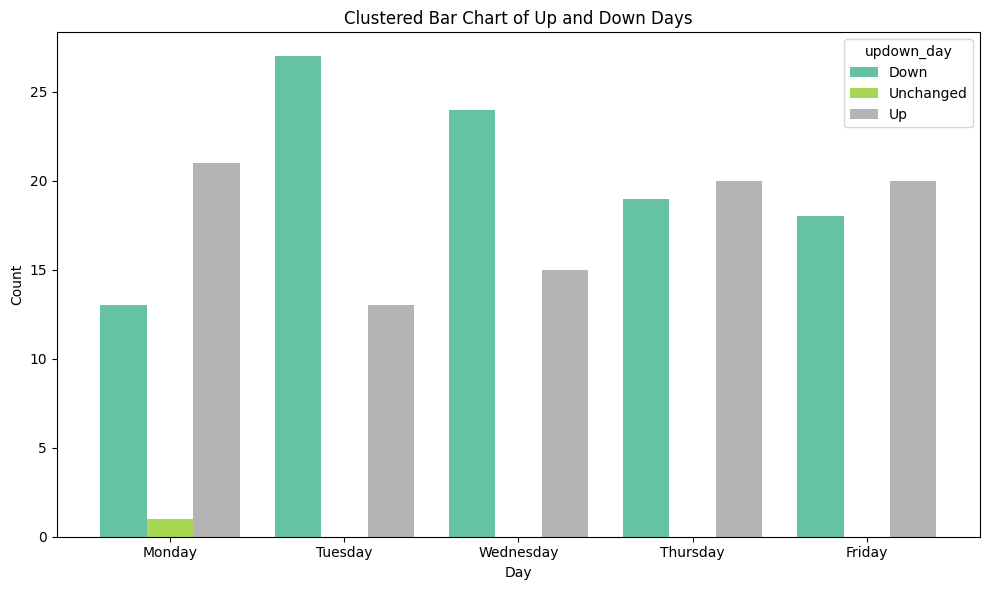

In [38]:
# Create cluster bar chart

# Drop the '% Up' column as we are interested in plotting the counts for 'Up' and 'Down'
df_pvtDay_plot = df_pvtDay.drop(columns='% Up')

# Plotting the pivot table as a clustered bar chart
df_pvtDay_plot.plot(kind='bar', figsize=(10, 6), width=0.8, colormap='Set2')

# Adding titles and labels
plt.title('Clustered Bar Chart of Up and Down Days')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal for better readability

# Show the plot
plt.tight_layout()
plt.show()

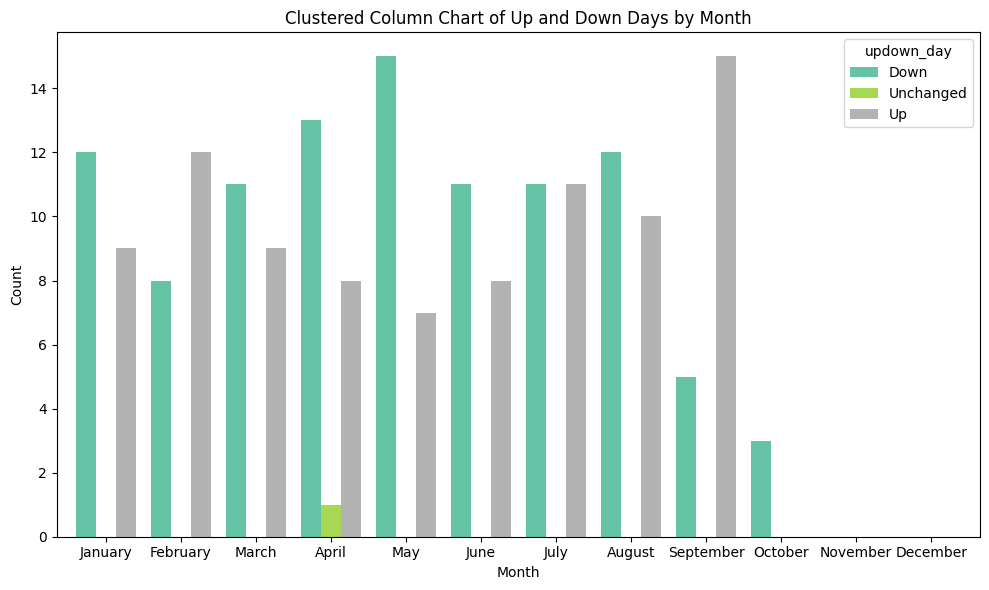

In [39]:
df_pvtMonth_plot = df_pvtMonth.drop(columns='% Up')

# Plot the pivot table as a clustered column chart (vertical bars)
df_pvtMonth_plot.plot(kind='bar', figsize=(10, 6), width=0.8, colormap='Set2')

# Adding titles and labels
plt.title('Clustered Column Chart of Up and Down Days by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep month labels horizontal for better readability

# Show the plot
plt.tight_layout()  # Ensure the layout is nicely spaced
plt.show()

My Line Graph

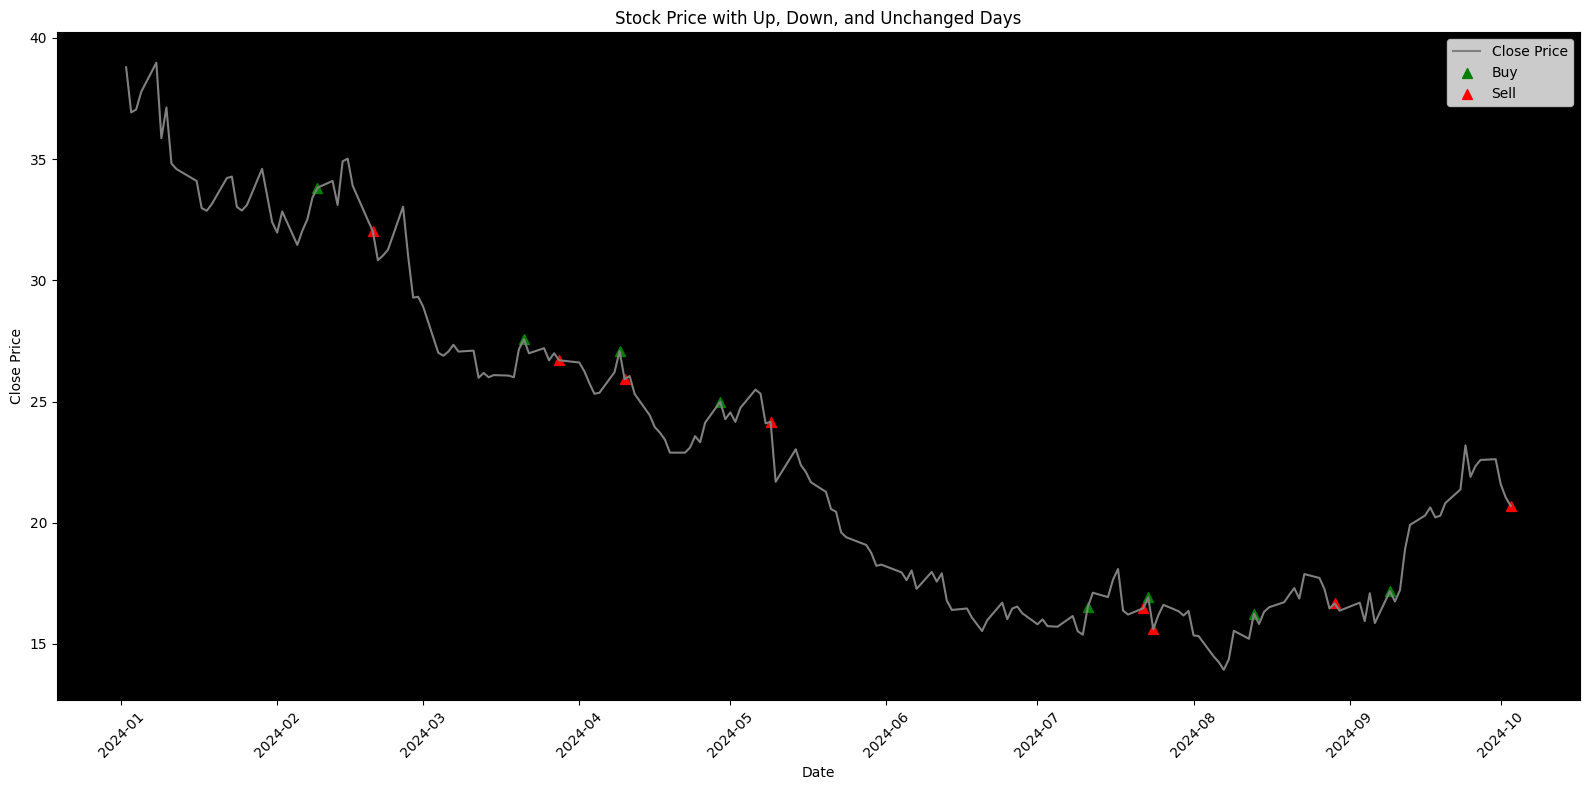

In [40]:
plt.figure(figsize=(16, 8))
# Plotting the line graph for 'Close' prices
plt.plot(df['Date'], df['Close'], label='Close Price', color='gray')

# Highlight up days in green
plt.scatter(df['Date'][buy_signal], df['Close'][buy_signal], marker='^', s=50, color='green', label='Buy')

# Highlight down days in red
plt.scatter(df['Date'][sell_signal], df['Close'][sell_signal], marker='^', s=50, color='red', label='Sell')

# # Highlight unchanged days in blue
# plt.scatter(df['Date'][unch], df['Close'][unch], color='blue', label='Unchanged')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price with Up, Down, and Unchanged Days')
plt.legend()

plt.gca().set_facecolor('black')  # Set the background color to black

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# # Plot the line graph with arrows indicating the direction of crossover
# plt.figure(figsize=(16, 8))
# plt.plot(df_sql.index, df_sql['close'], label='Close Price', color='gray')
# plt.gca().set_facecolor('black')  # Set the background color to black
# # Highlight up days in green
# plt.scatter(df_sql['date'][buy_signal], df_sql['close'][buy_signal], color='green', label='Buy')

git checkout staging => switch between branches.<BR>
git fetch origin => update your local repository with the latest changes from the remote branch<BR>
git pull origin staging => Merge the remote staging branch into your local staging branch<BR>
git add . => add all changes in the current directory<BR>
git push origin staging